## Image preprocessing code (we have already preprocessed and hosted the dataset on roboflow) so you do not need to run this code explicitly

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

class ImageProcessing:
    def __init__(self, img_height, img_width, no_channels, tol=10, sigmaX=10):

        ''' Initialzation of variables'''

        self.img_height = img_height
        self.img_width = img_width
        self.no_channels = no_channels
        self.tol = tol
        self.sigmaX = sigmaX

    def cropping_2D(self, img, is_cropping = False):

        '''This function is used for Cropping the extra dark part of the GRAY images'''

        mask = img>self.tol
        return img[np.ix_(mask.any(1),mask.any(0))]

    def cropping_3D(self, img, is_cropping = False):

        '''This function is used for Cropping the extra dark part of the RGB images'''

        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>self.tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # if image is too dark we return the image
            return img
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]  #for channel_1 (R)
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]  #for channel_2 (G)
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]  #for channel_3 (B)
            img = np.stack([img1,img2,img3],axis=-1)
        return img

    def Gaussian_blur(self, img, is_gaussianblur = False):

        '''This function is used for adding Gaussian blur (image smoothing technique) which helps in reducing noise in the image.'''

        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0),self.sigmaX),-4,128)
        return img

    def draw_circle(self,img, is_drawcircle = True):

        '''This function is used for drawing a circle from the center of the image.'''

        x = int(self.img_width/2)
        y = int(self.img_height/2)
        r = np.amin((x,y))     # finding radius to draw a circle from the center of the image
        circle_img = np.zeros((self.img_height, self.img_width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        return img

    def image_preprocessing(self, img, is_cropping = True, is_gaussianblur = True):

        """
        This function takes an image -> crops the extra dark part, resizes, draw a circle on it, and finally adds a gaussian blur to the images
        Args : image - (numpy.ndarray) an image which we need to process
           cropping - (boolean) whether to perform cropping of extra part(True by Default) or not(False)
           gaussian_blur - (boolean) whether to apply gaussian blur to an image(True by Default) or not(False)
        Output : (numpy.ndarray) preprocessed image
        """

        if img.ndim == 2:
            img = self.cropping_2D(img, is_cropping)  #calling cropping_2D for a GRAY image
        else:
            img = self.cropping_3D(img, is_cropping)  #calling cropping_3D for a RGB image
        img = cv2.resize(img, (self.img_height, self.img_width))  # resizing the image with specified values
        # img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = self.draw_circle(img)  #calling draw_circle
        img = self.Gaussian_blur(img, is_gaussianblur) #calling Gaussian_blur
        return img

In [ ]:
import cv2
import numpy as np
from PIL import Image


def preprocess_pil_image(input_image_pil,imgh=224,imgw=224,channels=3):
    # Convert PIL image to numpy array
    input_image_np = np.array(input_image_pil)

    # Initialize the ImageProcessing class
    img_processor = ImageProcessing(imgh,imgw,channels)

    # Perform image preprocessing using the ImageProcessing class
    preprocessed_image_np = img_processor.image_preprocessing(input_image_np)

    # Convert preprocessed numpy array back to PIL image
    preprocessed_image_pil = Image.fromarray(preprocessed_image_np)

    return preprocessed_image_pil


In [ ]:
from PIL import Image

# Load your input PIL image
input_image_pil = Image.open("/content/hello.img")

# Preprocess the image using the function
preprocessed_image_pil = preprocess_pil_image(input_image_pil)

# You can save or display the preprocessed image as needed
preprocessed_image_pil.save("preprocessed_image.jpg")
# preprocessed_image_pil.show()


In [ ]:
single_image_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
img_tensor=single_image_transform(preprocessed_image_pil)

In [ ]:
def run_inference(model,img_tensor):

In [ ]:
img_tensor.shape

torch.Size([3, 224, 224])

In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Quantum transfer learning {#quantum_transfer_learning}
=========================

::: {.meta}
:property=\"og:description\": Combine PyTorch and PennyLane to train a
hybrid quantum-classical image classifier using transfer learning.
:property=\"og:image\":
<https://pennylane.ai/qml/_images/transfer_images.png>
:::

*Author: Andrea Mari --- Posted: 19 December 2019. Last updated: 28
January 2021.*

In this tutorial we apply a machine learning method, known as *transfer
learning*, to an image classifier based on a hybrid classical-quantum
network.

This example follows the general structure of the PyTorch [tutorial on
transfer
learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
by Sasank Chilamkurthy, with the crucial difference of using a quantum
circuit to perform the final classification task.

More details on this topic can be found in the research paper \[1\]
([Mari et al. (2019)](https://arxiv.org/abs/1912.08278)).

Introduction
------------

Transfer learning is a well-established technique for training
artificial neural networks (see e.g., Ref. \[2\]), which is based on the
general intuition that if a pre-trained network is good at solving a
given problem, then, with just a bit of additional training, it can be
used to also solve a different but related problem.

As discussed in Ref. \[1\], this idea can be formalized in terms of two
abstract networks $A$ and $B$, independently from their quantum or
classical physical nature.

|

![](../demonstrations/quantum_transfer_learning/transfer_learning_general.png){.align-center}

|

As sketched in the above figure, one can give the following **general
definition of the transfer learning method**:

1.  Take a network $A$ that has been pre-trained on a dataset $D_A$ and
    for a given task $T_A$.
2.  Remove some of the final layers. In this way, the resulting
    truncated network $A'$ can be used as a feature extractor.
3.  Connect a new trainable network $B$ at the end of the pre-trained
    network $A'$.
4.  Keep the weights of $A'$ constant, and train the final block $B$
    with a new dataset $D_B$ and/or for a new task of interest $T_B$.

When dealing with hybrid systems, depending on the physical nature
(classical or quantum) of the networks $A$ and $B$, one can have
different implementations of transfer learning as

summarized in following table:

|

::: {.rst-class}
docstable
:::

  -------------------------------------------------------------------------
  Network A   Network B   Transfer learning scheme
  ----------- ----------- -------------------------------------------------
  Classical   Classical   CC - Standard classical method. See e.g., Ref.
                          \[2\].

  Classical   Quantum     CQ - **Hybrid model presented in this tutorial.**

  Quantum     Classical   QC - Model studied in Ref. \[1\].

  Quantum     Quantum     QQ - Model studied in Ref. \[1\].
  -------------------------------------------------------------------------

Classical-to-quantum transfer learning
--------------------------------------

We focus on the CQ transfer learning scheme discussed in the previous
section and we give a specific example.

1.  As pre-trained network $A$ we use **ResNet18**, a deep residual
    neural network introduced by Microsoft in Ref. \[3\], which is
    pre-trained on the *ImageNet* dataset.
2.  After removing its final layer we obtain $A'$, a pre-processing
    block which maps any input high-resolution image into 512 abstract
    features.
3.  Such features are classified by a 4-qubit \"dressed quantum
    circuit\" $B$, i.e., a variational quantum circuit sandwiched
    between two classical layers.
4.  The hybrid model is trained, keeping $A'$ constant, on the
    *Hymenoptera* dataset (a small subclass of ImageNet) containing
    images of *ants* and *bees*.

A graphical representation of the full data processing pipeline is given
in the figure below.

![](../demonstrations/quantum_transfer_learning/transfer_learning_c2q.png){.align-center}


General setup
=============

::: {.note}
::: {.title}
Note
:::

To use the PyTorch interface in PennyLane, you must first [install
PyTorch](https://pytorch.org/get-started/locally/#start-locally).
:::

In addition to *PennyLane*, we will also need some standard *PyTorch*
libraries and the plotting library *matplotlib*.


In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 46.0 MB/s eta 0:00:00
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2


In [ ]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
# os.environ["OMP_NUM_THREADS"] = "1"

Setting of the main hyper-parameters of the model
=================================================

::: {.note}
::: {.title}
Note
:::

To reproduce the results of Ref. \[1\], `num_epochs` should be set to
`30` which may take a long time. We suggest to first try with
`num_epochs=1` and, if everything runs smoothly, increase it to a larger
value.
:::


In [ ]:
n_qubits = 8                # Number of qubits
step = 0.0008               # Learning rate
batch_size = 16             # Number of samples for each training step
num_epochs = 10              # Number of training epochs
q_depth = 4                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer
step_size=10  # given in lr_scheduler

In [ ]:
n_qubits = 4             # Number of qubits
step = 0.001               # Learning rate
batch_size = 32             # Number of samples for each training step
num_epochs = 10              # Number of training epochs
q_depth = 6                # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.05              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

We initialize a PennyLane device with a `default.qubit` backend.


In [ ]:
dev = qml.device("lightning.qubit", wires=n_qubits)

We configure PyTorch to use CUDA only if available. Otherwise the CPU is
used.


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Dataset loading
===============

::: {.note}
::: {.title}
Note
:::

The dataset containing images of *ants* and *bees* can be downloaded
[here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and
should be extracted in the subfolder `../_data/hymenoptera_data`.
:::

This is a very small dataset (roughly 250 images), too small for
training from scratch a classical or quantum model, however it is enough
when using *transfer learning* approach.

The PyTorch packages `torchvision` and `torch.utils.data` are used for
loading the dataset and performing standard preliminary image
operations: resize, center, crop, normalize, *etc.*


## Downloading our idrid dataset hosted on Roboflow

In [ ]:
# !wget 'https://app.roboflow.com/ds/7fCe8COjHA?key=u6dgB5TFOp'
# !unzip '/content/7fCe8COjHA?key=u6dgB5TFOp' -d '/content/idrid'
# !wget 'https://app.roboflow.com/ds/2cMzmTSbxt?key=wZqVOncNpp'
!unzip '/content/drive/MyDrive/grid finale/full_final_dataset.zip' -d '/content/idrid'

# !unzip '/content/drive/MyDrive/grid 5.0 aj/idrid_all_aug.zip' -d '/content/idrid'

## image preprocessing

## preprocessing Test

## Creating dataloader

In [ ]:

from torch.utils.data import DataLoader
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            # transforms.Lambda(load_ben_color_transform_pil),
            # transforms.Resize(224),
            # transforms.CenterCrop(224),
            # transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            # transforms.Normalize([0.64917645 ,0.53531784, 0.49883134],[0.37539118 ,0.31598417 ,0.19043433])
            # Mean: [0.64917645 0.53531784 0.49883134]
# Standard Deviation: [0.37539118 0.31598417 0.19043433]
            # Normalize input channels using mean values and standard deviations of ImageNet.
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            # transforms.Lambda(load_ben_color_transform_pil),
            # transforms.Resize(224),
            # transforms.CenterCrop(224),
            # transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            # transforms.Normalize([0.64917645 ,0.53531784, 0.49883134],[0.37539118 ,0.31598417 ,0.19043433])
            # transforms.Normalize([0.62922242, 0.5377338,  0.49774495],[0.36688716, 0.30804136, 0.18360957])
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "test": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            # transforms.Lambda(load_ben_color_transform_pil),
            # transforms.Resize(224),
            # transforms.CenterCrop(224),
            # transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            # transforms.Normalize([0.64917645 ,0.53531784, 0.49883134],[0.37539118 ,0.31598417 ,0.19043433])
            # transforms.Normalize([0.62922242, 0.5377338,  0.49774495],[0.36688716, 0.30804136, 0.18360957])
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/content/idrid"
sample_fraction = 1

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        data_transforms[x]
    )
    for x in ["train", "val", "test"]
}

# Adjust the dataset sizes to use only 10% of the data
for x in ["train", "val", "test"]:
    image_datasets[x].samples = [
        image_datasets[x].samples[i] for i in range(0, len(image_datasets[x]), int(1 / sample_fraction))
    ]

# Get the sizes of each dataset
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}

# Get the class names
class_names = image_datasets["train"].classes

# Initialize dataloaders
batch_size = 16  # You can adjust the batch size

dataloaders = {
    x: DataLoader(
        image_datasets[x],
        batch_size=batch_size,
        shuffle=True if x == "train" else False  # Shuffle only for training data
    )
    for x in ["train", "val", "test"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    # mean = np.array([0.62922242, 0.5377338,  0.49774495])
    # std = np.array([0.36688716, 0.30804136, 0.18360957])
    # mean=[0.64917645 ,0.53531784, 0.49883134]
    # std=[0.37539118 ,0.31598417 ,0.19043433]
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Let us show a batch of the test data, just to have an idea of the
classification problem.


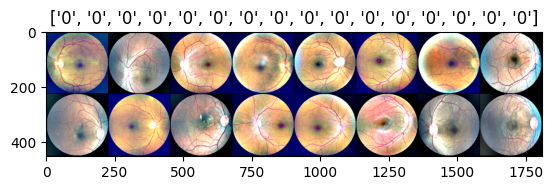

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["val"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "val","test"]
}

In [ ]:
len(dataloaders['train'])

161

Variational quantum circuit
===========================

We first define some quantum layers that will compose the quantum
circuit.


In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

Now we define the quantum circuit through the PennyLane
[qnode]{.title-ref} decorator .

The structure is that of a typical variational quantum circuit:

-   **Embedding layer:** All qubits are first initialized in a balanced
    superposition of *up* and *down* states, then they are rotated
    according to the input parameters (local embedding).
-   **Variational layers:** A sequence of trainable rotation layers and
    constant entangling layers is applied.
-   **Measurement layer:** For each qubit, the local expectation value
    of the $Z$ operator is measured. This produces a classical output
    vector, suitable for additional post-processing.


In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

Dressed quantum circuit
=======================

We can now define a custom `torch.nn.Module` representing a *dressed*
quantum circuit.

This is a concatenation of:

-   A classical pre-processing layer (`nn.Linear`).
-   A classical activation function (`torch.tanh`).
-   A constant `np.pi/2.0` scaling.
-   The previously defined quantum circuit (`quantum_net`).
-   A classical post-processing layer (`nn.Linear`).

The input of the module is a batch of vectors with 512 real parameters
(features) and the output is a batch of vectors with two real outputs
(associated with the two classes of images: *ants* and *bees*).


In [ ]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(2048, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 3)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

## DressedQunatumNet with softmax layer

Hybrid classical-quantum model
==============================

We are finally ready to build our full hybrid classical-quantum network.
We follow the *transfer learning* approach:

1.  First load the classical pre-trained network *ResNet18* from the
    `torchvision.models` zoo.
2.  Freeze all the weights since they should not be trained.
3.  Replace the last fully connected layer with our trainable dressed
    quantum circuit (`DressedQuantumNet`).

::: {.note}
::: {.title}
Note
:::

The *ResNet18* model is automatically downloaded by PyTorch and it may
take several minutes (only the first time).
:::


In [ ]:
# model_hybrid = torchvision.models.resnet50()
# Load the pretrained model
model_hybrid = torchvision.models.resnet18(pretrained=False)
# Get the input dimension of last layer

# Replace the last layer with a new one with 3 outputs
model_hybrid.fc = torch.nn.Linear(model_hybrid.fc.in_features, 3)
# Load the state dict from the .pth file
state_dict = torch.load('/content/drive/MyDrive/grid finale/final_dataset_manual_manip_even.pth')

# Load the state dict into the model
model_hybrid.load_state_dict(state_dict)

# Move the model to the device
# model = model.to(device)
'''
# feature_size=512
for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18

model_hybrid.fc = DressedQuantumNet()

for param in model_hybrid.fc.parameters():
    param.requires_grad = True
# model_hybrid.classifier = DressedQuantumNet()

# Then, unfreeze the last 10 layers
# for param in list(model_hybrid.parameters())[-10:]:
#     param.requires_grad = True
'''
# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model_hybrid

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model_hybrid)


+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |   36864    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.1.conv1.weight     |   36864    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |   36864    |
|     layer1.1.bn2.weight      |     64     |
|      layer1.1.bn2.bias       |     64     |
|    layer2.0.conv1.weight     |   73728    |
|     layer2.0.bn1.weight      |    128     |
|      layer2.0.bn1.bias       |    128     |
|    layer2.0.conv2.weight     |  

11178051

# Vgg + Resnet 18

Training and results
====================

Before training the network we need to specify the *loss* function.

We use, as usual in classification problem, the *cross-entropy* which is
directly available within `torch.nn`.


In [ ]:
criterion = nn.CrossEntropyLoss()
# criterion=nn.BCELoss()

We also initialize the *Adam optimizer* which is called at each training
step in order to update the weights of the model.


In [ ]:
optimizer_hybrid = optim.Adam(filter(lambda p: p.requires_grad, model_hybrid.parameters()), lr=step)

We schedule to reduce the learning rate by a factor of
`gamma_lr_scheduler` every 10 epochs.


In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

What follows is a training function that will be called later. This
function should return a trained model that can be used to make
predictions (classifications).


In [ ]:
num_epochs=25

In [ ]:
# just for trying and testing
images_lis=[]
labels_lis=[]
for inputs, labels in dataloaders['train']:
  images_lis.append(inputs)
  labels_lis.append(labels)
  break
image_tensor=images_lis[0][0]
print(image_tensor.shape)

## Code for training the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

We are ready to perform the actual training process.


In [ ]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)
'''
Resnet18 10 ep -> 0.8636
'''

Training started:
Phase: train Epoch: 1/25 Loss: 0.7101 Acc: 0.7646        
Phase: validation   Epoch: 1/25 Loss: 0.6919 Acc: 0.7025        
Phase: train Epoch: 2/25 Loss: 0.4957 Acc: 0.8771        
Phase: validation   Epoch: 2/25 Loss: 0.6284 Acc: 0.7025        
Phase: train Epoch: 3/25 Loss: 0.4028 Acc: 0.9052        
Phase: validation   Epoch: 3/25 Loss: 0.5575 Acc: 0.7934        
Phase: train Epoch: 4/25 Loss: 0.3443 Acc: 0.9083        
Phase: validation   Epoch: 4/25 Loss: 0.5509 Acc: 0.7769        


We first define a visualization function for a batch of test data.


In [ ]:
torch.save(model_hybrid,"final_model.pth")

In [ ]:
def test_model(model, criterion, dataloader, phase):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    n_batches = len(dataloader)
    it = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():  # Disable gradient calculation during inference
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # Print iteration results
        running_loss += loss.item() * inputs.size(0)
        batch_corrects = torch.sum(preds == labels.data).item()
        running_corrects += batch_corrects
        print(
            "Phase: {} Iter: {}/{} Batch Loss: {:.4f}".format(
                phase, it + 1, n_batches, loss.item()
            ),
            end="\r",
            flush=True,
        )
        it += 1

    # Print results for the entire phase (validation or test)
    phase_loss = running_loss / len(dataloader.dataset)
    phase_acc = running_corrects / len(dataloader.dataset)
    print(
        "Phase: {} Loss: {:.4f} Acc: {:.4f}        ".format(
            phase, phase_loss, phase_acc
        )
    )
    return phase_loss, phase_acc

# Example usage:
# For validation data
val_loss, val_acc = test_model(model_hybrid, criterion, dataloaders["val"], "val")

# For test data
test_loss, test_acc = test_model(model_hybrid, criterion, dataloaders["test"], "test")
# model_hybrid1 details:-
# Phase: val Loss: 0.2376 Acc: 0.9071
# Phase: test Loss: 0.2604 Acc: 0.8761

Phase: val Loss: 0.0717 Acc: 0.9906        
Phase: test Loss: 0.0813 Acc: 0.9781        


Hello border

In [ ]:
!pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 13.6 MB/s eta 0:00:00


In [ ]:
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.7 MB/s eta 0:00:00


In [ ]:
import sklearn
import numpy as np

In [ ]:
from sklearn.datasets import make_classification
# set the model to evaluation mode
model_hybrid.eval()

# initialize lists to store the features and labels
features = []
labels = []

# iterate over the trainloader
for data, label in dataloaders["train"]:
    # get the features from the model
    with torch.no_grad():
        data,label=data.to(device), label.to(device)
        output = model_hybrid(data)
        output = output.view(output.size(0), -1)
        features.append(output.cpu().numpy())
        labels.append(label.cpu().numpy())

# convert the lists to numpy arrays
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# create the scikit-learn classification dataset
X_train = features
y_train = labels
# <------------------------------------------------------->
# getting test data
features = []
labels = []

# iterate over the trainloader
for data, label in dataloaders["test"]:
    # get the features from the model
    with torch.no_grad():
        data,label=data.to(device), label.to(device)
        output = model_hybrid(data)
        output = output.view(output.size(0), -1)
        features.append(output.cpu().numpy())
        labels.append(label.cpu().numpy())

# convert the lists to numpy arrays
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# create the scikit-learn classification dataset
# X_test, y_test = make_classification(n_features=2048, n_classes=3)
X_test = features
y_test = labels
# similarly do for valid and test.

In [ ]:
X_train.shape

(2562, 3)

## Visualize the 3 fetures


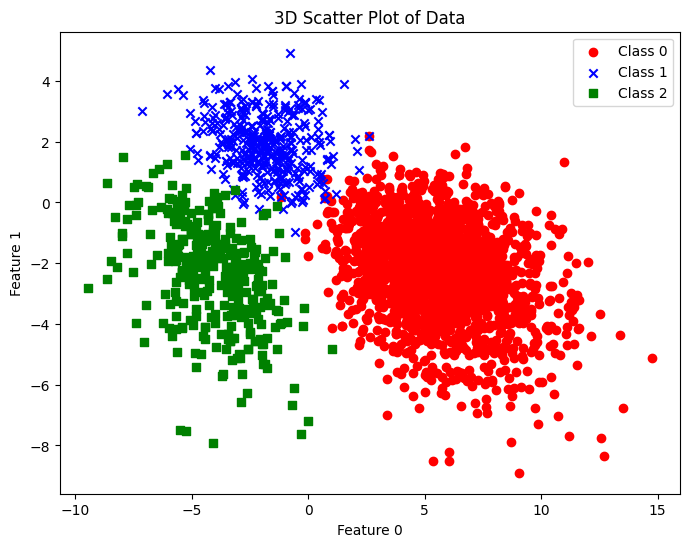

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have a NumPy array for X_train and y_train
# Replace X_train and y_train with your actual data

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Scatter points for each class
ax.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], label='Class 0', c='red', marker='o')
ax.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label='Class 1', c='blue', marker='x')
ax.scatter(X_train[y_train == 2][:, 0], X_train[y_train == 2][:, 1], label='Class 2', c='green', marker='s')

ax.set_xlabel('Feature 0')
ax.set_ylabel('Feature 1')

plt.legend()
plt.title('3D Scatter Plot of Data')
plt.show()


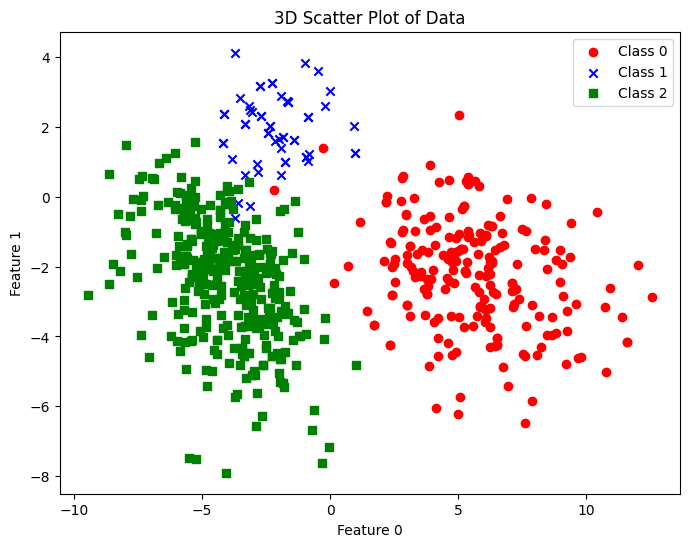

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have a NumPy array for X_train and y_train
# Replace X_train and y_train with your actual data

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Scatter points for each class
ax.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], label='Class 0', c='red', marker='o')
ax.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], label='Class 1', c='blue', marker='x')
ax.scatter(X_train[y_train == 2][:, 0], X_train[y_train == 2][:, 1], label='Class 2', c='green', marker='s')

ax.set_xlabel('Feature 0')
ax.set_ylabel('Feature 1')

plt.legend()
plt.title('3D Scatter Plot of Data')
plt.show()

In [ ]:
!pip install plotly

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

In [ ]:
import plotly.express as px

# Assuming you have a pandas DataFrame for X_train and a NumPy array for y_train
# Replace X_train and y_train with your actual data

# Create a DataFrame with the features and labels
import pandas as pd
df = pd.DataFrame({'Feature0': X_test[:, 0], 'Feature1': X_test[:, 1], 'Feature2': X_test[:, 2], 'Class': y_test})

# Create an interactive 3D scatter plot
fig = px.scatter_3d(df, x='Feature0', y='Feature1', z='Feature2', color='Class',
                     color_continuous_scale='Viridis', title='Interactive 3D Scatter Plot')
fig.show()
fig.write_html('test_plot_3d.html')


In [ ]:
# visualize training and testing together
import plotly.express as px

# Assuming you have pandas DataFrames for X_train, X_test, and NumPy arrays for y_train, y_test
# Replace X_train, X_test, y_train, and y_test with your actual data

# Create DataFrames for training and testing data with labels
import pandas as pd
df_train = pd.DataFrame({'Feature0': X_train[:, 0], 'Feature1': X_train[:, 1], 'Feature2': X_train[:, 2], 'Class': y_train, 'Dataset': 'Training'})
df_test = pd.DataFrame({'Feature0': X_test[:, 0], 'Feature1': X_test[:, 1], 'Feature2': X_test[:, 2], 'Class': y_test, 'Dataset': 'Testing'})

# Concatenate the training and testing DataFrames
df_combined = pd.concat([df_train, df_test], ignore_index=True)

# Create an interactive 3D scatter plot with both training and testing data
fig = px.scatter_3d(df_combined, x='Feature0', y='Feature1', z='Feature2', color='Class', symbol='Dataset',
                     color_continuous_scale='Viridis', title='Interactive 3D Scatter Plot (Training and Testing Data)')
fig.show()


IndexError: ignored

In [ ]:
from sklearn.decomposition import PCA

# initialize PCA
pca = PCA(n_components=160)

# fit and transform the data
X_train = pca.fit_transform(X_train)

# initialize PCA
pca = PCA(n_components=160)

# fit and transform the data
X_test = pca.fit_transform(X_test)


ValueError: ignored

In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit_machine_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512710 sha256=b1ed1148f13cba8004cd1d0b13a11e7327e3a255d11a53e344f0566ace36b6fc
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:
!pip install qiskit_algorithms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.1/307.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

## try all 3 classifiers a)VQC b) Estimator QNN or Sampler QNN c) QSVC

## vqc

In [ ]:
num_inputs=3

In [ ]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=2)

In [ ]:
# Make the labels in this format
y_cat_train = np.empty(y_train.shape, dtype=str)
y_cat_train[y_train == 0] = "A"
y_cat_train[y_train == 1] = "B"
y_cat_train[y_train == 2] = "C"
# print(y_cat)

# doiing same thing with test labels also
# Make the labels in this format
y_cat_test = np.empty(y_test.shape, dtype=str)
y_cat_test[y_test == 0] = "A"
y_cat_test[y_test == 1] = "B"
y_cat_test[y_test == 2] = "C"
# print(y_cat)

In [ ]:
X_test.shape

(320, 3)

In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph,
)

In [ ]:
# cls=SVC(gamma=2, C=1)
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
cls=SVC()

In [ ]:
cls.fit(X_train,y_train)
print(cls.score(X_test,y_test))

0.971875


In [ ]:
# number of qubits is equal to the number of features
num_qubits = 2

# number of steps performed during the training procedure
tau = 100

# regularization parameter
C = 1000
# code for pegasos
from qiskit import BasicAer
from qiskit.circuit.library import ZFeatureMap
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms import PegasosQSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel

algorithm_globals.random_seed = 12345

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)

qkernel = FidelityQuantumKernel(feature_map=feature_map)



pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

# training
pegasos_qsvc.fit(X_train, y_train)

# testing
pegasos_score = pegasos_qsvc.score(X_test, y_test)
print(f"PegasosQSVC classification test score: {pegasos_score}")

PegasosQSVC classification test score: 0.5333333333333333


In [ ]:
X_train[:30]

In [ ]:
# code for quantum kernel with svc
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

from sklearn.svm import SVC

adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

adhoc_svc.fit(X_train, y_train)

adhoc_score_callable_function = adhoc_svc.score(X_test, y_test)

print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

KeyboardInterrupt: ignored

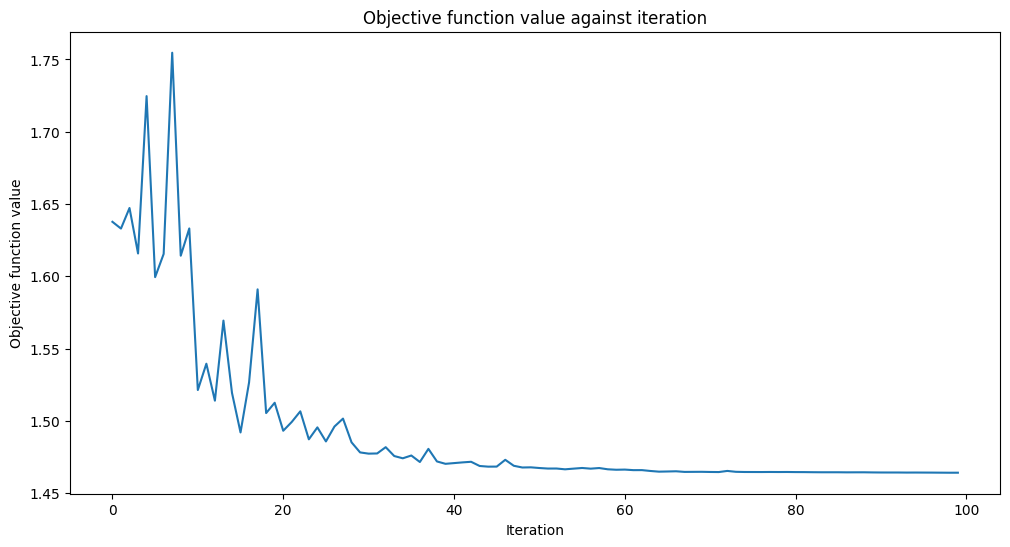

0.515625

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X_train, y_cat_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_test, y_cat_test)